# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Домашнее задание 4

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash;  60 баллов





-----

In [ ]:
# Bot check

# HW_ID: phds_hw4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
import numpy as np
import os
import subprocess
from tqdm.notebook import tqdm
import shutil

import torch
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torch.nn import BCEWithLogitsLoss

import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
from sklearn.utils.random import sample_without_replacement

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Условие
В этом задании вам предстоит реализовать модель **U-Net** для задачи семантической сегментации. Для оценки качества вам понадобится реализовать метрику IoU.


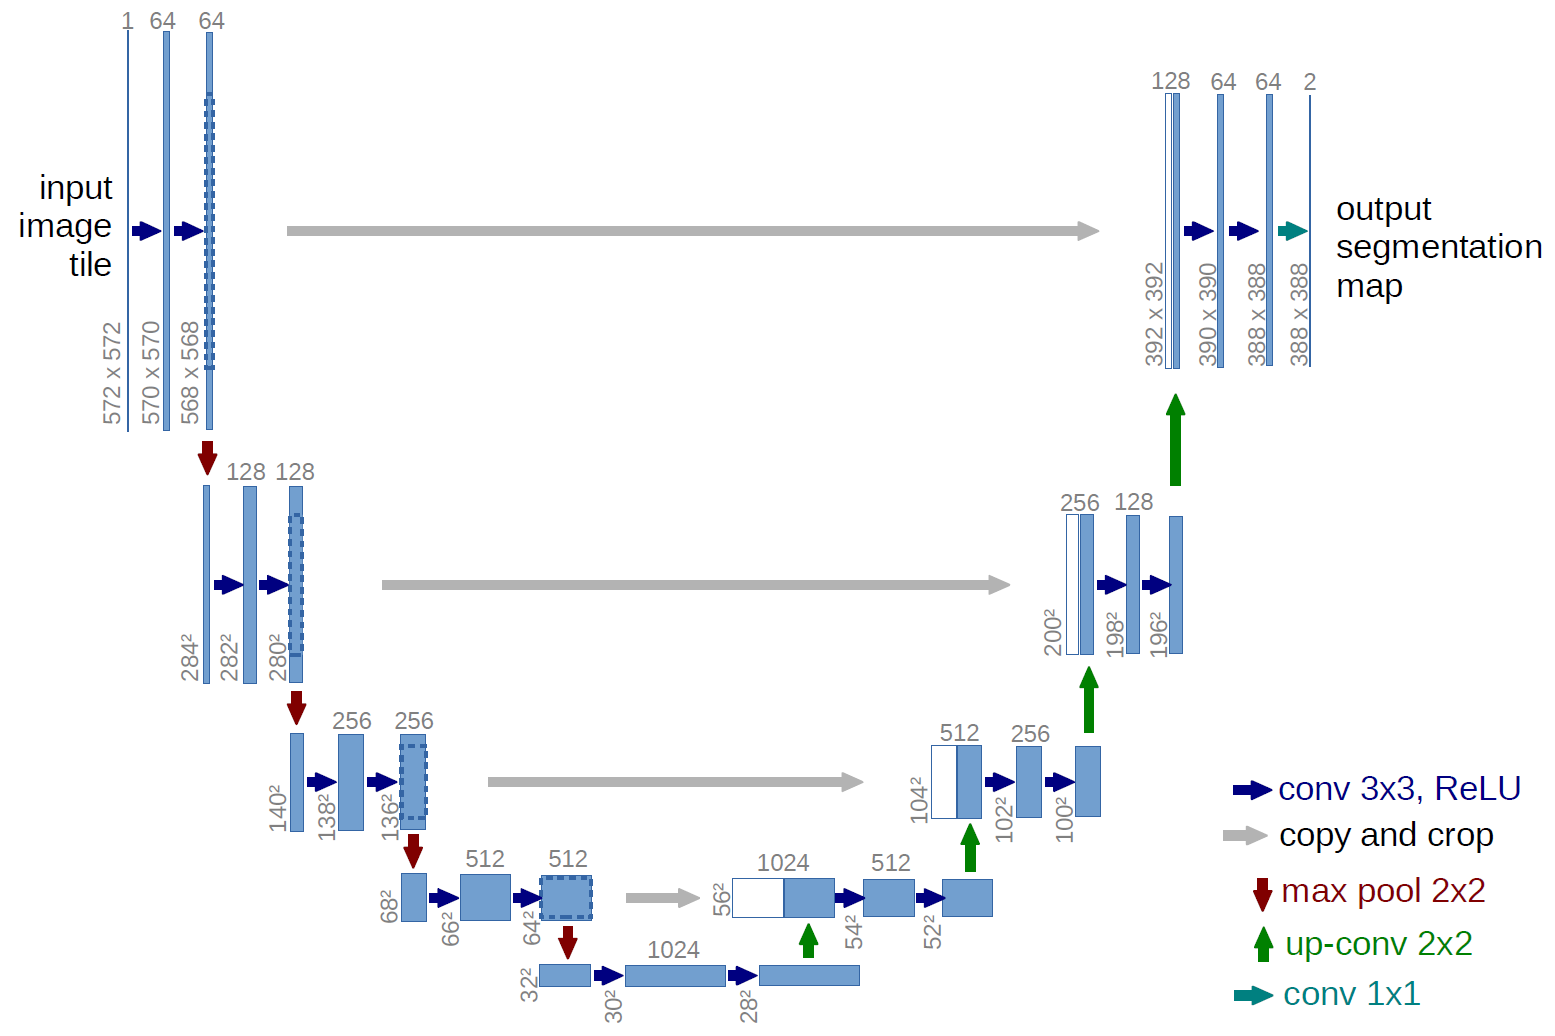

## 1.1. Данные

### Профиль биология
Мы предлагаем вам поработать с датасетом [раковых клеток HT29 различных фенотипов](https://bbbc.broadinstitute.org/BBBC018). В данном задании мы будем выделять границы клеток. Далее расписан процес загрузки данных.

**Внимание.** Нужно скачать данные [отсюда](https://drive.google.com/file/d/1is6qQzqz7tWqlEpRynUcjjehIONiS-D5/view?usp=share_link) и положить на свой диск.

Подготовим данные

Определим путь к данным

In [ ]:
DATA_PATH = '/content/drive/MyDrive/data.zip'

Разархивируем их

In [ ]:
! unzip $DATA_PATH

Данные уже разделены на трейн и валидацию. В папках `BBBC018_v1_images-fixed` и `BBBC018_v1_outlines` лежат изображения клеток и их маски соответсвенно. Для изображений клеток из папки `test` доступны только изображения клеток. Как работает на них ваша сеть, вы посмотрите в конце задания.

Посмотрим на количество данных

In [ ]:
TRAIN_IMAGES_PATH = '/content/BBBC018_v1_images-fixed/train'
VAL_IMAGES_PATH = '/content/BBBC018_v1_images-fixed/val'

TRAIN_MASKS_PATH = '/content/BBBC018_v1_outlines/train'
VAL_MASKS_PATH = '/content/BBBC018_v1_outlines/val'

In [ ]:
print(f'Размер обучающего датасета: {len(os.listdir(TRAIN_IMAGES_PATH))}')
print(f'Размер валидационного датасета: {len(os.listdir(VAL_IMAGES_PATH))}')

Как вы видите, размер датасетов очень небольшой.

Изображения и маски имеют одинаковое начало названия (номер). Название файла маски отличается тем, что часть `actin.DIB` меняется на `cells`, а также сам файл имеет другой формат -- png вместо bmp. Так можно получить изображение и его маску из трейна.



In [ ]:
img_name = "00735-actin.DIB.bmp"
mask_name = img_name.replace('actin.DIB.bmp', 'cells.png')

img_path = os.path.join(TRAIN_IMAGES_PATH, img_name)
mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

Визуализруем изображение и маску.

In [ ]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path), 'gray')
plt.axis("off");

### Профиль физика
Мы предлагаем вам поработать с датасетом [Electron Microscopy Particle Segmentation](https://www.kaggle.com/datasets/batuhanyil/electron-microscopy-particle-segmentation). В данном задании мы будем выделять границы объектов в изображении электронного микроскопа

**Внимание.** Нужно скачать данные и положить на свой диск.

Подготовим данные

Определим путь к данным

In [ ]:
DATA_PATH = '/content/drive/MyDrive//archive.zip'

Разархивируем их

In [ ]:
! unzip $DATA_PATH

Данные не разделены на трейн и валидацию, нам необходимо сделать это самостоятельно. В папках `images` и `segmaps` лежат изображения клеток и их маски соответсвенно.

Посмотрим на количество данных

In [ ]:
IMAGES_PATH = '/content/images'

MASKS_PATH = '/content/segmaps'

In [ ]:
# Разделяем наш датасет на трейн, валидацию и тест

# Доля изображений в валидации
VAL_FRAC = 0.2
TEST_FRAC = 0.1

images_filename = sorted(os.listdir(IMAGES_PATH))

# Выделяем часть изображений для валидации
# Выбираем случайные изображения из выборки для валидции, с установленным random_state
num_images = len(images_filename)
num_val = int(num_images * VAL_FRAC)
num_test = int(num_images * TEST_FRAC)
indices = sample_without_replacement(num_images, num_val+num_test, random_state=42)
val_indices = sample_without_replacement(num_val+num_test, num_val, random_state=42)

val_images = np.take(np.take(images_filename, indices), val_indices)
test_images = set(np.take(images_filename, indices)) - set(val_images)
train_images = set(images_filename) - set(val_images) - set(test_images)

print(f'train images = {len(train_images)} | val images = {num_val} | test images = {num_test}')

for path in [IMAGES_PATH, MASKS_PATH]:
    TRAIN_DIR = os.path.join(path, "train")
    os.makedirs(TRAIN_DIR, exist_ok=True)

    # Папка с изображениями для валидации
    VAL_DIR = os.path.join(path, "val")
    os.makedirs(VAL_DIR, exist_ok=True)

    # Папка с изображениями для теста
    TEST_DIR = os.path.join(path, "test")
    os.makedirs(TEST_DIR, exist_ok=True)

# Сохраняем валидационную выборку
for image_filename in val_images:
    for path in [IMAGES_PATH, MASKS_PATH]:
        # Папка с изображениями для валидации
        VAL_DIR = os.path.join(path, "val")
        source = os.path.join(path, image_filename)
        destination = os.path.join(VAL_DIR, image_filename)
        shutil.copy(source, destination)
        os.remove(source)

# Сохраняем тестовую выборку
for image_filename in test_images:
    for path in [IMAGES_PATH, MASKS_PATH]:
        # Папка с изображениями для теста
        TEST_DIR = os.path.join(path, "test")
        source = os.path.join(path, image_filename)
        destination = os.path.join(TEST_DIR, image_filename)
        shutil.copy(source, destination)
        os.remove(source)

for image_filename in train_images:
    for path in [IMAGES_PATH, MASKS_PATH]:
        TRAIN_DIR = os.path.join(path, "train")
        source = os.path.join(path, image_filename)
        destination = os.path.join(TRAIN_DIR, image_filename)
        shutil.copy(source, destination)
        os.remove(source)

In [ ]:
TRAIN_IMAGES_PATH = IMAGES_PATH+'/train'
VAL_IMAGES_PATH = IMAGES_PATH+'/val'
TEST_IMAGES_PATH = IMAGES_PATH+'/test'

TRAIN_MASKS_PATH = MASKS_PATH+'/train'
VAL_MASKS_PATH = MASKS_PATH+'/val'
TEST_MASKS_PATH = MASKS_PATH+'/test'

Как вы видите, размер датасетов довольно небольшой.

Изображения и маски имеют одинаковые названия. Так можно получить изображение и его маску из трейна.



In [ ]:
img_name = "03a1d18cc6.png"

img_path = os.path.join(TRAIN_IMAGES_PATH, img_name)
mask_path = os.path.join(TRAIN_MASKS_PATH, img_name)

Визуализруем изображение и маску.

In [ ]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
mask = Image.open(mask_path)
transform = transforms.PILToTensor()
mask = transform(mask)
mask[mask>0]=1
plt.imshow(mask.permute((1, 2, 0)), 'gray')
plt.axis("off");

Поскольку исходный датасет довольно мал, без аугментаций обойтись не получится. В нашем случае обучающим примером служит пара (изображение, маска), поэтому и агументировать их нужно одновременно. Такая аугментация удобно реализована в библиотеке `albumentations`. Посмотрим на пример применения этой библиотеки

In [ ]:
image = np.array(Image.open(img_path))
mask = np.array(Image.open(mask_path))

In [ ]:
image.shape, mask.shape

Агументации определяются похожим на torchvision образом

In [ ]:
import albumentations as A

aug = A.Compose([
    A.Flip(p=0.6),
    A.Rotate(limit=180, p=0.9, always_apply=True, crop_border=True),
    A.RandomBrightnessContrast(p=0.9)]
    )

augmented = aug(image=image, mask=mask)

image_aug = augmented['image']
mask_aug = augmented['mask']

В данном случае мы использовали обрезание картинки, поэтому ее размер изменился. Однако при обучении обрезку картинки использовать не стоит, поскольку нам нужно собирать их в батчи.

In [ ]:
image_aug.shape, mask_aug.shape

Посмотрим на результат применения

In [ ]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(image_aug)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(mask_aug.squeeze(), cmap='Greys_r')
plt.axis("off");

## 1.2. Реализуем класс датасет для задачи семантической сегментации.

На семинаре мы применяли аугментации прямо во время обучения и выносили их в функцию для обучения, однако для `albumentations` это делать сильно неудобно, поскольку эта библиотека работает с `numpy` массивами. В данном случае есть два варианта: аугментировать датасет заранее и сохранить на диск; вынести агументацию в класс для датасета и делать ее "на лету" при получении объекта. Мы используем второй подход.

Как обычно, чтобы создать свой класс датасет, нужно наследовать его от класса `Dataset` из torch.utils.data, и переопределить функции `__len__` и `__getitem__`.  

In [ ]:
class CellsDataset(Dataset):
    def __init__(self, data_path, mask_path, aug=None):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        # Файлы с изображениями и масками
        self.files = os.listdir(data_path)
        self.mask_files = os.listdir(self.mask_path)

        assert len(self.files) == len(self.mask_files)

        # Сортируем файлы, чтобы было соответствие
        # между изображениями и масками за счет порядка следования.
        self.files.sort()
        self.mask_files.sort()

        # агументация из albumentations
        self.aug = aug

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Загружаем изображение и маску
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.mask_files[idx])
        

        # Пробразуем изображение и маску в numpy массив (расскомментируйте нужное!)
        <..>
        
        # датасет биологии
#         input = np.array(Image.open(file_name), dtype=np.uint8)
#         target = np.array(Image.open(mask_name), dtype=np.uint8)

        # датасет физики
#         input = Image.open(file_name)
#         target = Image.open(mask_name)
#         transform = transforms.Resize((512, 512))
#         input = transform(input)
#         target = transform(target)
#         input = np.array(input, dtype=np.uint8)
#         target = np.array(target, dtype=np.uint8)

        # применяем аугментацию
        if self.aug:
          augmented = self.aug(image=input, mask=target)
          input = augmented['image']
          target = augmented['mask']

        # исправим порядок размерностей
        input = input.transpose(2, 0, 1)

        # Приводим к torch tensor
        input = torch.tensor(input, dtype=torch.float32)
        target = torch.from_numpy(target)

        # Приводим таргет/маску к такому виду,
        # чтобы его значения были от 0 до 1
        target = (target > 0).int().unsqueeze(0)

        return input, target

Получим датасет из данных. Для обучающего датасета используем аугментацию, а для валидационного - нет.

In [ ]:
# Датасет с данными для обучения и вадидации

aug = A.Compose([
    A.Flip(p=0.8),
    A.Rotate(limit=180, p=0.7),
    A.RandomBrightnessContrast(p=0.9)])

train_dataset = CellsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, aug=aug)
val_dataset = CellsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH)

Визуализируем

In [ ]:
i = 1

plt.figure(figsize=(15, 7))

# Заметьте: мы сохраняем семпл в отдельную переменную, поскольку при каждом обращении будет применяться аугментация и изображение будет выглядеть иначе!
sample = train_dataset[i]

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(sample[0].permute(1, 2, 0).int())
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(sample[1].squeeze(), cmap='Greys_r')
plt.axis("off");

print("Значения в маске и количество значений:", np.unique(train_dataset[i][1], return_counts=True))

## 2. Релизация метрики IoU
Реализуйте метрику IoU. Она вам понадобится далее для оценивания результатов предсказания модели.


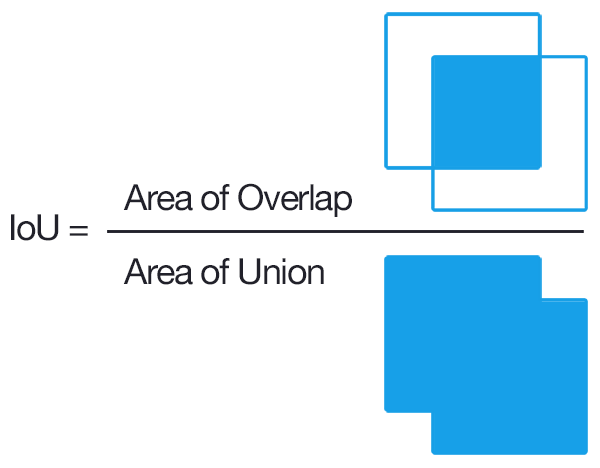

In [ ]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает среднее IoU для всех элементов батча """
    # Площадь пересечения в пикселях
    intersection = (predicted_mask_batch & target_mask_batch).sum(dim=(1, 2, 3))
    # Площадь объединения в пикселях
    union = (predicted_mask_batch | target_mask_batch).sum(dim=(1, 2, 3))
    iou = <ваш код>
    return iou

In [ ]:
predicted_mask_batch = torch.ones((1, 1, 10, 10)).bool()
target_mask_batch =  torch.ones((1, 1, 10, 10)).bool()
assert torch.allclose(iou(predicted_mask_batch, target_mask_batch), torch.tensor(1.0))

## 3. Реализация модели
- Реализуйте модель U-Net.




In [ ]:
def conv_bn_relu(in_channels, out_channels, kernel=3, stride=1, padding=1):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
    return net


class Stacked2ConvsBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Stacked2ConvsBlock, self).__init__()
        self.blocks = nn.Sequential(
            conv_bn_relu(in_channels, out_channels),
            conv_bn_relu(out_channels, out_channels)
        )

    def forward(self, net):
        net = self.blocks(net)
        return net


class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()

        # Понижаем число каналов
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, stride=2)

        # Стакаем с симметричным слоем из левой половины "U".
        # Число каналов входной карты при этом удваивается.
        self.convolve = Stacked2ConvsBlock(2 * in_channels, out_channels)

    def forward(self, left_net, right_net):
        right_net = self.upsample(right_net)
        # конкатенируем векторы из левой и правой половины
        net = <ваш код>
        # применяем свертку
        net = <ваш код>
        return net


class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSamplingBlock, self).__init__()
        self.blocks = nn.Sequential(
            nn.MaxPool2d(2, 2),
            Stacked2ConvsBlock(in_channels, out_channels)
        )

    def forward(self, net):
        return self.blocks(net)


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.init_conv = Stacked2ConvsBlock(3, 64)

        self.downsample_1 = DownSamplingBlock(64, 128)
        self.downsample_2 = DownSamplingBlock(128, 256)
        self.downsample_3 = DownSamplingBlock(256, 512)
        self.downsample_4 = DownSamplingBlock(512, 1024)

        # В середине есть блок без пары с 1024 каналами
        # с ним конкатенировать некого, потому просто свернём его
        self.upconv = Stacked2ConvsBlock(1024, 512)

        # Подъём. Аналогично.
        self.upsample_1 = UpSamplingBlock(512, 256)
        self.upsample_2 = UpSamplingBlock(256, 128)
        self.upsample_3 = UpSamplingBlock(128, 64)
        # Чтобы учесть входной слой после самой первой свёртки и согласовать размерности
        self.upsample_4 = UpSamplingBlock(64, 64)

        # Предсказание
        self.agg_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        net0 = self.init_conv(x) # 3 --> 64

        net1 = self.downsample_1(net0) # 64 --> 128
        net2 = self.downsample_2(net1) # 128 --> 256
        net3 = self.downsample_3(net2) # 256 --> 512
        net = self.downsample_4(net3) # 512 --> 1024

        net = self.upconv(net) # 1024 --> 512

        net = self.upsample_1(net3, net) # 512 --> 256
        net = <ваш код> # 256 --> 128
        net = <ваш код> # 128 --> 64
        net = <ваш код> # 64 --> 64

        net = self.agg_conv(net) # 64 --> 1

        return net

## Обучение модели

- Напишите пайплайн обучения и обучите модель.
  - Обязательно сохраняйте веса модели, например после каждого улучшения метрики на валидации.
  - Сохраняйте историю обучения.
  - Визуализируйте предсказания (маски) для некоторых заранее выбранных изображений во время обучения, можно с определенным интервалом.
  - Визуализируйте графики лоссов и метрик во время обучения, можно с определенным интревалом.

- Визуализируйте работу модели на тестовых данных. Подсказка: для тестовых данных можно использовать тот же класс датасета, что и выше, куда можно передавать одинаковые директории (масками мы все равно не будем пользоваться).

**Внимание.** В данном случае вы имеете дело со сложной задачей, в которой:
  - мало данных
  - наблюдается сильный дисбаланс классов (большая часть сегментационной маски относится к фону)

Для борьбы с этими проблемами можно использовать аугментацию данных (например, повороты, отражения, изменение яркости и контраста), перевзвешивание классов в loss-функции, использовать менее чувствительную к дисбалансу класс функцию потерь (например, `DiceLoss` из `torchgeometry.losses.dice`).

Поставьте следующие эксперименты:

1. Поскольку данных явно очень мало, уменьшите размер сети (количество блоков: например, уберите последний блок так, чтобы максимальное количество каналов в сети было равно 512, а не 1024), и обучите уменьшенную сеть на исходных данных без аугментаций. Саму сеть вынесите в отдельный класс `SmallUnet`. В качестве лосса используйте обычный `torch.nn.BCEWithLogitsLoss`. Прокомментируйте результат. Не застревайте надолго на этом пункте.
2. Добавьте аугментации и обучите уменьшенную сеть с ними. Советуем использовать повороты, отражения, изменение яркости и контраста (все они есть выше, нужно лишь немного подправить). В качестве лосса используйте обычный `torch.nn.BCEWithLogitsLoss`. Прокомментируйте результат. Не застревайте надолго на этом пункте.
3. К аугментациям добавьте вес положительного класса в лоссе `torch.nn.BCEWithLogitsLoss`. Обратите внимание на описание параметра `pos_weight`. Прокомментируйте результат.
4. Используя все наработки из предыдущих пунктов обучите итоговый вариант сети. Здесь уже можно попробовать использовать большую сеть. Если вы решите взять `DiceLoss`, обратите внимание на вход `torchgeometry.losses.dice.DiceLoss` (подсказка: наша реализация выдает на вход только одно число для каждого пикселя, а для этого лосса нужны еще логиты для класса 1, поэтому архитектуру сети придется немного поменять). **Итоговый вариант сети должен преодолеть порог 0.2 по метрике IoU на валидационном датасете.**


Для облегчения выполнения задания вам даны вспомогательные функции.

In [ ]:
def vis_dataset(val_dataset, segment_model, n_img=4, savefig_dir=None):
    plt.figure(figsize=(20, n_img * 3.5))

    for i, (image, mask) in enumerate(val_dataset):
        if i == n_img:
            break

        plt.subplot(n_img, 4, 4 * i + 1)
        plt.imshow(image.permute(1, 2, 0).cpu().int())
        plt.axis("off")
        plt.title("Изображение")

        plt.subplot(n_img, 4, 4 * i + 2)
        plt.imshow(mask.squeeze().cpu())
        plt.axis("off")
        plt.title("Реальная маска")

        with torch.no_grad():
            pred = segment_model(image.unsqueeze(dim=0).to(device)).squeeze().cpu()

        plt.subplot(n_img, 4, 4 * i + 3)
        plt.imshow(pred > 0.)
        plt.axis("off")
        plt.title("Предсказанная маска")

        plt.subplot(n_img, 4, 4 * i + 4)
        plt.imshow(pred)
        plt.axis("off")
        plt.title("Логиты")

    if savefig_dir is not None:
        plt.savefig(os.path.join(savefig_dir, f"results_epoch_{epoch:03d}.png"))
    plt.show()

In [ ]:
def train(
        segment_model,
        optimizer,
        criterion,
        train_dataloader,
        val_dataloader,
        state_dict_path,
        device="cpu",
        n_epochs=20,
        show_interval=20,
        savefig_dir=None,
    ):

    # Set history
    history = {}
    history["train_loss"] = []
    history["train_iou"] = []
    history["val_loss"] = []
    history["val_iou"] = []

    # Set start epoch number
    start_epoch = 0

    # Load state dict
    if os.path.exists(state_dict_path):
        state = torch.load(state_dict_path)
        segment_model.load_state_dict(state["model"])
        optimizer.load_state_dict(state["optimizer"])
        history = state["history"]
        start_epoch = state["epoch"] + 1

    n_train_batches = len(train_dataloader)
    n_val_batches = len(val_dataloader)

    best_val_iou = 0.

    end_epoch = start_epoch + n_epochs

    if savefig_dir is not None:
        if not os.path.exists(savefig_dir):
            os.mkdir(savefig_dir)

    for epoch in range(start_epoch, start_epoch + n_epochs):

        print(f"Epoch {epoch}/{end_epoch}")

        segment_model.train()

        train_loss = 0.
        train_iou = 0.

        for i, (image, mask) in enumerate(tqdm(train_dataloader)):
            image = image.to(device)
            mask = mask.to(device)

            pred = segment_model(image)
            loss = criterion(pred, mask.float())
            loss.backward()

            # будем аккумулировать градиенты так, чтобы делать 1 шаг за эпоху, поскольку у нас всего 41 изображение на эпоху
            if i == (n_train_batches - 1):
                optimizer.step()
                optimizer.zero_grad()

            loss_ = float(loss.detach().data)
            # предсказываем маску по вероятности 0.5 <=> logit > 0
            iou_ = float(iou(pred.detach() > 0., mask > 0).data)

            train_loss += loss_
            train_iou += iou_

        train_loss = train_loss / n_train_batches
        train_iou = train_iou / n_train_batches

        history["train_loss"].append(train_loss)
        history["train_iou"].append(train_iou)

        print('')
        print(f"Total Train:\tloss\t{train_loss:.5f}"
              f"\t\tIoU\t{train_iou:.5f}")

        segment_model.eval()

        val_loss = 0.
        val_iou = 0.

        with torch.no_grad():
            for image, mask in tqdm(val_dataloader):
                image, mask = image.to(device), mask.to(device)
                pred = segment_model(image)
                loss = criterion(pred, mask.float())
                loss_ = float(loss.data)
                # предсказываем маску по вероятности 0.5 <=> logit > 0
                iou_ = float(iou(pred > 0., mask > 0).data)

                val_iou += iou_
                val_loss += loss_

        val_loss = val_loss / n_val_batches
        val_iou = val_iou / n_val_batches

        history["val_loss"].append(val_loss)
        history["val_iou"].append(val_iou)

        if history["val_iou"][-1] > best_val_iou:
            torch.save({
                "model": segment_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "history": history,
                "epoch": epoch,
            }, state_dict_path)
            best_val_iou = history["val_iou"][-1]

        print('')
        print(f"Toatal Valid:\tloss\t{val_loss:.5f}"
              f"\t\tIoU\t{val_iou:.5f}"
              f"\t\tbest IoU\t{best_val_iou:.5f}")
        print('-' * 100)

        clear_output(wait=True)

        if epoch % show_interval == show_interval - 1:

            # Отрисовка графиков
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(history["train_loss"], label='train')
            plt.plot(history["val_loss"], label='test')
            plt.title("Loss")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(history["train_iou"], label='train')
            plt.plot(history["val_iou"], label='test')
            plt.title("IoU")
            plt.legend();

            plt.show()

            # Отрисовка результатов
            vis_dataset(val_dataset, segment_model, n_img=4, savefig_dir=None)

Пример задания даталоадеров

In [ ]:
batch_size = 6

train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## 4. Эксперименты

### Эксперимент 1

Обучим небольшую сеть на исходных данных

In [ ]:
class SmallUnet(nn.Module):
    def __init__(self):
        super(SmallUnet, self).__init__()

    def forward(self, x):
      pass

In [ ]:
# модель, оптимизатор, обучение, критерий

**Вывод**
<..>

### Эксперимент 2

Добавим аугментации

In [ ]:
# ваш код

**Вывод**
<..>

### Эксперимент 3

Добавим веса к лоссу дополнительно к аугментациям

In [ ]:
# ваш код

**Вывод**
<..>

### Эксперимент 4

Обучим большую сеть в предыдущем сетапе

In [ ]:
# ваш код

**Вывод**
<..>

### Дополнительное улучшение модели

Как вы могли заметить, до сих пор мы выбирали, к какому классу относить пиксель по порогу 0.5 (эквивалентно logit > 0). Тем не менее в задачах с сильным дисбалансом классов иногда получается улучшить качество с помощью подбора порога уверенности модели. Интуиция здесь понятна: пусть, например, у вас классификатор сильно смещен в сторону класса 1, тогда вполне логично отдавать класс 1 только тогда, когда классификатор в этом очень уверен.

Для вашей лучше модели реализуйте подсчет IoU с предсказанием по порогу. Не забудьте, что сеть предсказывает логиты, а не вероятности, а также то, что реализованная функция для IoU считает среднее по батчу (тогда вам нужно брать батч размера 1). Постройте график. Прокомментируйте результаты.

In [ ]:
state = torch.load(state_dict_path, map_location=device)

In [ ]:
segment_model.load_state_dict(state["model"])
segment_model.eval();

In [ ]:
def calculate_iou_with_threshold(segment_model, val_dataset, threshold=0.5):
    pass

**Вывод**
<..>

## 5. Применение модели к тесту
Примените полученную лучшую модель к тестовым данным. Что вы можете сказать о качестве ее работы?

In [ ]:
# биология
TEST_IMAGES_PATH = '/content/BBBC018_v1_images-fixed/test'
TEST_MASKS_PATH = '/content/BBBC018_v1_images-fixed/test'

In [ ]:
# физика
TEST_IMAGES_PATH = '/content/images/test'
TEST_MASKS_PATH = '/content/segmaps/test'

In [ ]:
test_dataset = CellsDataset(TEST_IMAGES_PATH, TEST_MASKS_PATH)

In [ ]:
# применение и визуализация

**Вывод**
<..>